# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train_data_v2.json', 'r'))
val_data = json.load(open('NER_val_data_v2.json', 'r'))
test_data = json.load(open('NER_test_data_v2.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# LSTM Implementation

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            #  Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                #  Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # 128 Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
lstm_word2vec_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_word2vec_model.parameters(), lr=0.001)
# optimizer = optim.SGD(lstm_word2vec_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4640, Accuracy: 0.8883, F1: 0.2998
Validation: Loss: 0.3412, Accuracy: 0.9094, F1: 0.3716
Epoch 2/10
Training: Loss: 0.3083, Accuracy: 0.9162, F1: 0.4377
Validation: Loss: 0.3063, Accuracy: 0.9184, F1: 0.4575
Epoch 3/10
Training: Loss: 0.2654, Accuracy: 0.9250, F1: 0.5180
Validation: Loss: 0.2962, Accuracy: 0.9217, F1: 0.4977
Epoch 4/10
Training: Loss: 0.2352, Accuracy: 0.9320, F1: 0.5796
Validation: Loss: 0.2968, Accuracy: 0.9215, F1: 0.5277
Epoch 5/10
Training: Loss: 0.2090, Accuracy: 0.9383, F1: 0.6301
Validation: Loss: 0.3021, Accuracy: 0.9216, F1: 0.5355
Epoch 6/10
Training: Loss: 0.1867, Accuracy: 0.9440, F1: 0.6716
Validation: Loss: 0.3074, Accuracy: 0.9227, F1: 0.5469
Epoch 7/10
Training: Loss: 0.1663, Accuracy: 0.9496, F1: 0.7088
Validation: Loss: 0.3132, Accuracy: 0.9228, F1: 0.5456
Epoch 8/10
Training: Loss: 0.1494, Accuracy: 0.9545, F1: 0.7401
Validation: Loss: 0.3282, Accuracy: 0.9223, F1: 0.5547
Epoch 9/10
Training: Loss: 0.1349, Accuracy: 0.9

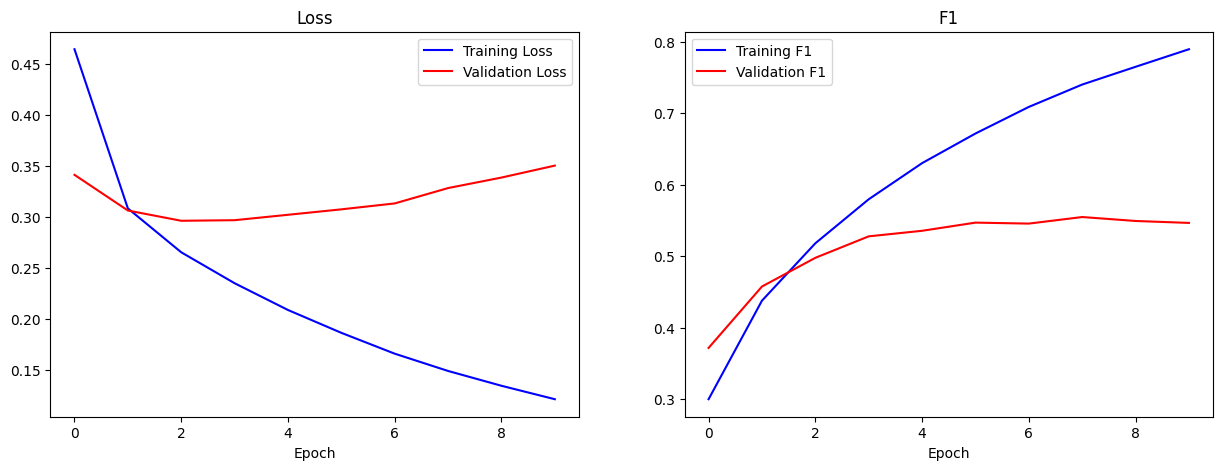

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [43]:
# fine_tune(lstm_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

Epoch 1/2
FineTuning: Loss: 0.3502, Accuracy: 0.9205, F1: 0.5465
Epoch 2/2
FineTuning: Loss: 0.3502, Accuracy: 0.9205, F1: 0.5465


In [44]:
test_accuracy, test_f1 = test("t1_model2_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.036595510624954364, 1: 0.05095541401273886, 2: 0.06380789022298455, 3: 0.026373626373626374, 4: 0.03152709359605912, 5: 0.0422740524781341, 6: 0.04515050167224081, 7: 0.13114754098360656, 8: 0.12041432887354338, 9: 0.22955974842767296, 10: 0.1773248407643312, 11: 0.10598705501618123, 12: 0.08541300527240774, 13: 0.10040160642570282, 14: 0.04360012457178449, 15: 0.051491365777080064, 16: 0.17632241813602015, 17: 0.15384615384615383, 18: 0.1411764705882353, 19: 0.10548523206751054, 20: 0.05355884425651868, 21: 0.08333333333333334, 22: 0.039999999999999994, 23: 0.14232209737827714, 24: 0.2222222222222222, 25: 0.15, 26: 0.06779661016949153}
Labelwise Accuracy Scores:
{0: 0.9764384559359067, 1: 0.2975206611570248, 2: 0.5406976744186046, 3: 0.22641509433962265, 4: 0.3096774193548387, 5: 0.42028985507246375, 6: 0.4153846153846154, 7: 0.6486486486486487, 8: 0.7284595300261096, 9: 0.8488372093023255, 10: 0.7963386727688787, 11: 0.7359550561797753, 12: 0.74539877300613

In [13]:
torch.save(lstm_word2vec_model, "t1_model2_word2vec.pt")

In [14]:
test_accuracy, test_f1 = test("t1_model2_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.036595510624954364, 1: 0.05095541401273886, 2: 0.06380789022298455, 3: 0.026373626373626374, 4: 0.03152709359605912, 5: 0.0422740524781341, 6: 0.04515050167224081, 7: 0.13114754098360656, 8: 0.12041432887354338, 9: 0.22955974842767296, 10: 0.1773248407643312, 11: 0.10598705501618123, 12: 0.08541300527240774, 13: 0.10040160642570282, 14: 0.04360012457178449, 15: 0.051491365777080064, 16: 0.17632241813602015, 17: 0.15384615384615383, 18: 0.1411764705882353, 19: 0.10548523206751054, 20: 0.05355884425651868, 21: 0.08333333333333334, 22: 0.039999999999999994, 23: 0.14232209737827714, 24: 0.2222222222222222, 25: 0.15, 26: 0.06779661016949153}
Labelwise Accuracy Scores:
{0: 0.9764384559359067, 1: 0.2975206611570248, 2: 0.5406976744186046, 3: 0.22641509433962265, 4: 0.3096774193548387, 5: 0.42028985507246375, 6: 0.4153846153846154, 7: 0.6486486486486487, 8: 0.7284595300261096, 9: 0.8488372093023255, 10: 0.7963386727688787, 11: 0.7359550561797753, 12: 0.74539877300613

# For GloVe Embeddings

In [15]:
input_size, hidden_size, output_size = 300, 128, 27

lstm_glove_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(lstm_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(lstm_glove_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [16]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5810, Accuracy: 0.8644, F1: 0.1398
Validation: Loss: 0.4898, Accuracy: 0.8807, F1: 0.2319
Epoch 2/10
Training: Loss: 0.4633, Accuracy: 0.8837, F1: 0.2484
Validation: Loss: 0.4538, Accuracy: 0.8870, F1: 0.2818
Epoch 3/10
Training: Loss: 0.4306, Accuracy: 0.8903, F1: 0.3061
Validation: Loss: 0.4351, Accuracy: 0.8902, F1: 0.3258
Epoch 4/10
Training: Loss: 0.4123, Accuracy: 0.8936, F1: 0.3468
Validation: Loss: 0.4277, Accuracy: 0.8922, F1: 0.3490
Epoch 5/10
Training: Loss: 0.3990, Accuracy: 0.8963, F1: 0.3683
Validation: Loss: 0.4245, Accuracy: 0.8927, F1: 0.3578
Epoch 6/10
Training: Loss: 0.3879, Accuracy: 0.8985, F1: 0.3871
Validation: Loss: 0.4233, Accuracy: 0.8926, F1: 0.3674
Epoch 7/10
Training: Loss: 0.3774, Accuracy: 0.9006, F1: 0.4001
Validation: Loss: 0.4245, Accuracy: 0.8912, F1: 0.3757
Epoch 8/10
Training: Loss: 0.3676, Accuracy: 0.9024, F1: 0.4124
Validation: Loss: 0.4256, Accuracy: 0.8910, F1: 0.3798
Epoch 9/10
Training: Loss: 0.3585, Accuracy: 0.9

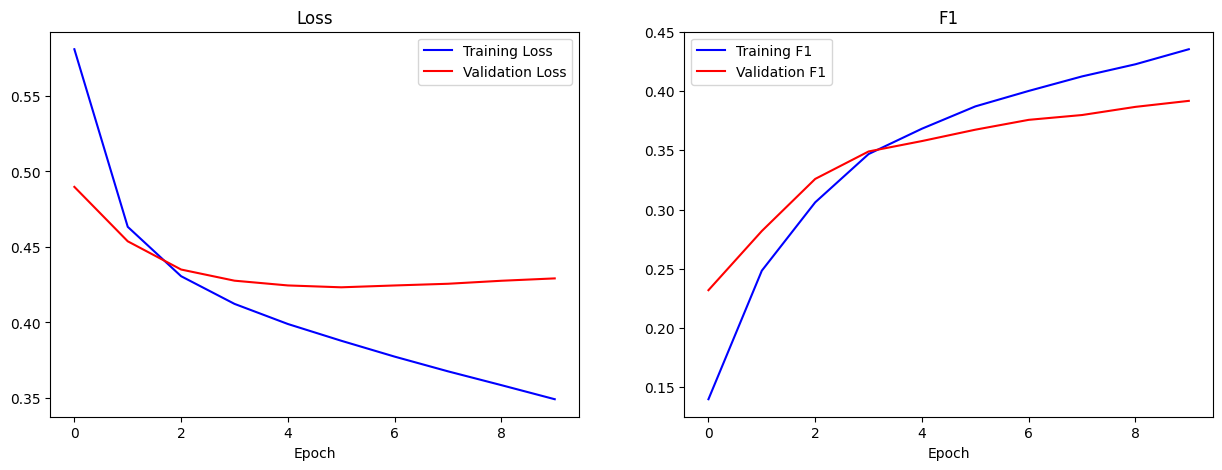

In [17]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [41]:
# fine_tune(lstm_glove_model, glove, val_data, criterion, optimizer, device='cuda', epochs=2)

Epoch 1/2


FineTuning: Loss: 0.4292, Accuracy: 0.8916, F1: 0.3917
Epoch 2/2
FineTuning: Loss: 0.4292, Accuracy: 0.8916, F1: 0.3917


In [42]:
test_accuracy, test_f1 = test(lstm_glove_model, glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.0410491888096382, 1: 0.05523809523809524, 2: 0.04679245283018867, 3: 0.0, 4: 0.014863748967795212, 5: 0.020795107033639144, 6: 0.044928044928044926, 7: 0.09322033898305085, 8: 0.06858832224685883, 9: 0.0639561443581544, 10: 0.06599522926053539, 11: 0.032677000418935905, 12: 0.057295645530939646, 13: 0.0375, 14: 0.06639004149377593, 15: 0.05379293893129771, 16: 0.11194029850746268, 17: 0.06666666666666667, 18: 0.03333333333333334, 19: 0.09701492537313433, 20: 0.02248677248677249, 21: 0.0, 22: 0.1212121212121212, 23: 0.4603174603174603, 24: 0.0, 25: 0.0, 26: 0.008163265306122448}
Labelwise Accuracy Scores:
{0: 0.9707938820101967, 1: 0.2396694214876033, 2: 0.5406976744186046, 3: 0.0, 4: 0.11612903225806452, 5: 0.18478260869565216, 6: 0.3282051282051282, 7: 0.5945945945945946, 8: 0.6057441253263708, 9: 0.5426356589147286, 10: 0.5697940503432495, 11: 0.21910112359550563, 12: 0.4601226993865031, 13: 0.10344827586206896, 14: 0.3615819209039548, 15: 0.755443886097152

In [20]:
torch.save(lstm_glove_model, "t1_model2_glove.pt")

In [21]:
test_accuracy, test_f1 = test("t1_model2_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.0410491888096382, 1: 0.05523809523809524, 2: 0.04679245283018867, 3: 0.0, 4: 0.014863748967795212, 5: 0.020795107033639144, 6: 0.044928044928044926, 7: 0.09322033898305085, 8: 0.06858832224685883, 9: 0.0639561443581544, 10: 0.06599522926053539, 11: 0.032677000418935905, 12: 0.057295645530939646, 13: 0.0375, 14: 0.06639004149377593, 15: 0.05379293893129771, 16: 0.11194029850746268, 17: 0.06666666666666667, 18: 0.03333333333333334, 19: 0.09701492537313433, 20: 0.02248677248677249, 21: 0.0, 22: 0.1212121212121212, 23: 0.4603174603174603, 24: 0.0, 25: 0.0, 26: 0.008163265306122448}
Labelwise Accuracy Scores:
{0: 0.9707938820101967, 1: 0.2396694214876033, 2: 0.5406976744186046, 3: 0.0, 4: 0.11612903225806452, 5: 0.18478260869565216, 6: 0.3282051282051282, 7: 0.5945945945945946, 8: 0.6057441253263708, 9: 0.5426356589147286, 10: 0.5697940503432495, 11: 0.21910112359550563, 12: 0.4601226993865031, 13: 0.10344827586206896, 14: 0.3615819209039548, 15: 0.755443886097152

# For FastText Embeddings

In [29]:
input_size, hidden_size, output_size = 300, 128, 27
lstm_fasttext_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_fasttext_model.parameters(), lr=0.001)
optimizer = optim.SGD(lstm_fasttext_model.parameters(), lr=0.1, momentum=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [30]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        lstm_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.6362, Accuracy: 0.8559, F1: 0.0820
Validation: Loss: 0.4980, Accuracy: 0.8781, F1: 0.1653
Epoch 2/10
Training: Loss: 0.4352, Accuracy: 0.8888, F1: 0.2676
Validation: Loss: 0.3884, Accuracy: 0.9005, F1: 0.3207
Epoch 3/10
Training: Loss: 0.3597, Accuracy: 0.9054, F1: 0.3584
Validation: Loss: 0.3403, Accuracy: 0.9111, F1: 0.3713
Epoch 4/10
Training: Loss: 0.3257, Accuracy: 0.9128, F1: 0.3950
Validation: Loss: 0.3158, Accuracy: 0.9154, F1: 0.3935
Epoch 5/10
Training: Loss: 0.3044, Accuracy: 0.9171, F1: 0.4174
Validation: Loss: 0.3016, Accuracy: 0.9189, F1: 0.4140
Epoch 6/10
Training: Loss: 0.2906, Accuracy: 0.9199, F1: 0.4346
Validation: Loss: 0.2960, Accuracy: 0.9212, F1: 0.4292
Epoch 7/10
Training: Loss: 0.2778, Accuracy: 0.9228, F1: 0.4518
Validation: Loss: 0.2893, Accuracy: 0.9220, F1: 0.4431
Epoch 8/10
Training: Loss: 0.2677, Accuracy: 0.9247, F1: 0.4710
Validation: Loss: 0.2856, Accuracy: 0.9231, F1: 0.4588
Epoch 9/10
Training: Loss: 0.2590, Accuracy: 0.9266, F1: 0.

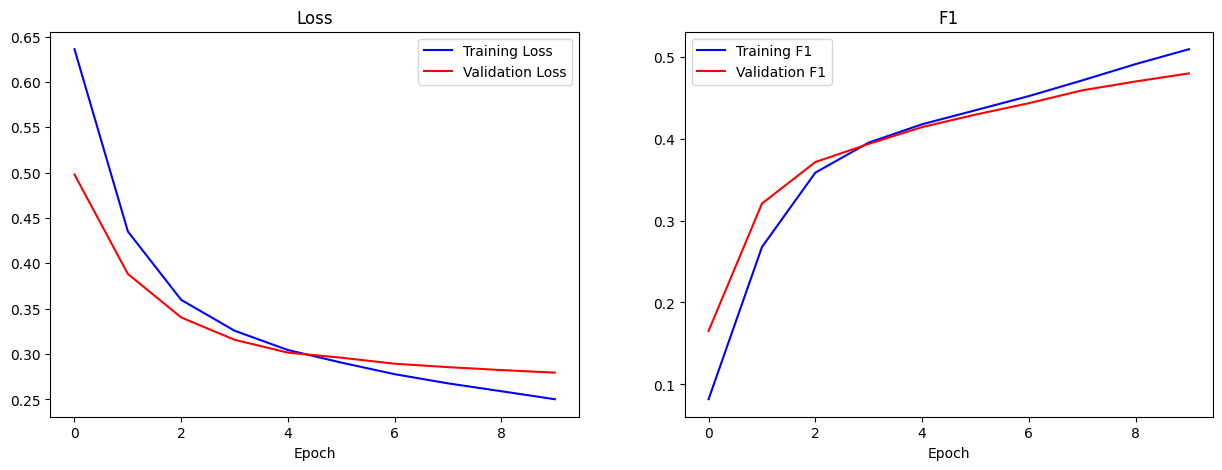

In [31]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [36]:
# fine_tune(lstm_fasttext_model, fasttext, val_data, criterion, optimizer, device='cuda', epochs=2)

Epoch 1/2
FineTuning: Loss: 0.2827, Accuracy: 0.9228, F1: 0.4818
Epoch 2/2
FineTuning: Loss: 0.2633, Accuracy: 0.9273, F1: 0.4957


In [37]:
test_accuracy, test_f1 = test(lstm_fasttext_model, fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.049548026750937016, 1: 0.02947845804988662, 2: 0.15646017699115045, 3: 0.016184971098265895, 4: 0.053797468354430375, 5: 0.051529193697868396, 6: 0.06203931203931205, 7: 0.08480346641906529, 8: 0.1238377007607777, 9: 0.185, 10: 0.15416154161541615, 11: 0.0894854586129754, 12: 0.0914396887159533, 13: 0.03968253968253968, 14: 0.05945385413066022, 15: 0.06081587205182711, 16: 0.14786967418546365, 17: 0.0, 18: 0.0, 19: 0.007272727272727273, 20: 0.06363636363636364, 21: 0.0, 22: 0.0, 23: 0.15343915343915343, 24: 0.05555555555555555, 25: 0.0, 26: 0.013605442176870748}
Labelwise Accuracy Scores:
{0: 0.9820830298616169, 1: 0.21487603305785125, 2: 0.6424418604651163, 3: 0.0880503144654088, 4: 0.27419354838709675, 5: 0.5036231884057971, 6: 0.517948717948718, 7: 0.6171171171171171, 8: 0.7650130548302873, 9: 0.8604651162790697, 10: 0.8604118993135011, 11: 0.6741573033707865, 12: 0.5766871165644172, 13: 0.08620689655172414, 14: 0.4858757062146893, 15: 0.8386376326074818, 

In [34]:
torch.save(lstm_fasttext_model, "t1_model2_fasttext.pt")

In [35]:
test_accuracy, test_f1 = test("t1_model2_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.04505377062320486, 1: 0.03131991051454138, 2: 0.17142857142857143, 3: 0.009740259740259742, 4: 0.04729064039408867, 5: 0.06730769230769232, 6: 0.08680555555555557, 7: 0.08959537572254334, 8: 0.09287402904424182, 9: 0.18227848101265823, 10: 0.1773248407643312, 11: 0.10067114093959732, 12: 0.07205387205387205, 13: 0.019672131147540982, 14: 0.058041958041958046, 15: 0.049955610189168886, 16: 0.2182741116751269, 17: 0.049999999999999996, 18: 0.03333333333333334, 19: 0.005194805194805195, 20: 0.05405405405405405, 21: 0.0, 22: 0.0, 23: 0.23157894736842105, 24: 0.05555555555555555, 25: 0.08333333333333333, 26: 0.037037037037037035}
Labelwise Accuracy Scores:
{0: 0.9825200291332847, 1: 0.23140495867768596, 2: 0.75, 3: 0.05660377358490566, 4: 0.3096774193548387, 5: 0.5072463768115942, 6: 0.6410256410256411, 7: 0.5585585585585585, 8: 0.7180156657963447, 9: 0.8372093023255814, 10: 0.7963386727688787, 11: 0.6741573033707865, 12: 0.656441717791411, 13: 0.05172413793103448